Mounted at /content/drive
Dataset preview:
            Start Date        End Date Charging Time (hh:mm:ss)  Energy (kWh)  \
0  2020-01-01 09:11:00  1/1/2020 11:20                  2:08:25        12.885   
1  2020-01-01 09:32:00  1/1/2020 11:19                  1:47:06         5.936   
2  2020-01-01 09:44:00  1/1/2020 10:57                  1:12:40         3.652   
3  2020-01-01 09:45:00  1/1/2020 10:45                  1:00:15         6.031   
4  2020-01-01 09:45:00  1/1/2020 15:08                  5:22:07        32.260   

  Port Type  Port Number Plug Type  
0   Level 2            2     J1772  
1   Level 2            2     J1772  
2   Level 2            2     J1772  
3   Level 2            1     J1772  
4   Level 2            1     J1772  

Data Split:
Training samples: 14067
Validation samples: 3015
Test samples: 3015
XGBoost version: 2.1.3
[0]	validation_0-rmse:9.17560
[1]	validation_0-rmse:9.09633
[2]	validation_0-rmse:9.01838
[3]	validation_0-rmse:8.94030
[4]	validation_0-rmse:8.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,251 (47.86 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 6.4090 - mae: 1.9559 - val_loss: 10.6174 - val_mae: 2.2616 - learning_rate: 0.0010
Epoch 2/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.2496 - mae: 1.9366 - val_loss: 10.6339 - val_mae: 2.2663 - learning_rate: 0.0010
Epoch 3/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.2888 - mae: 1.9348 - val_loss: 10.6172 - val_mae: 2.2595 - learning_rate: 0.0010
Epoch 4/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.2315 - mae: 1.9224 - val_loss: 10.6220 - val_mae: 2.2619 - learning_rate: 0.0010
Epoch 5/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.1944 - mae: 1.9307 - val_loss: 10.6226 - val_mae: 2.2614 - learning_rate: 0.0010
Epoch 6/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.2505 - mae: 1.9371 - val_loss: 10.6349 - val_mae: 2.2672 - learning_rate: 0.0010
Epoch 7/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.1903 - mae: 1.9310 - val_loss: 10.6225 - val_mae: 2.2605 - learning_rate:

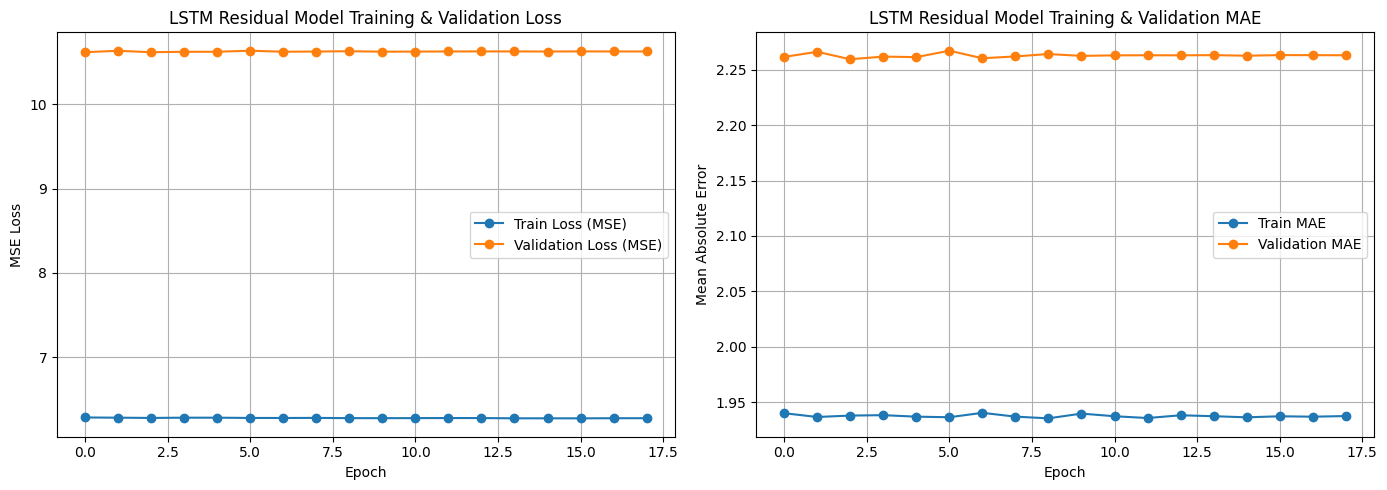

In [ ]:
# XGBoost + LSTM Stacking Ensemble on Residual Errors V1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------------------------------------------------
# 1. Mount Google Drive & Load Data
# ---------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/Data/2020_Data_V0.1.csv"
df = pd.read_csv(file_path)
print("Dataset preview:")
print(df.head())

# ---------------------------------------------------
# 2. Data Preprocessing & Feature Engineering
# ---------------------------------------------------
def convert_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df['Charging Time (seconds)'] = df['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)

# Process datetime and extract features.
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Start Hour'] = df['Start Date'].dt.hour
df['Start Day'] = df['Start Date'].dt.day
df['Start Month'] = df['Start Date'].dt.month
# NEW: Added day of week to capture weekly patterns.
df['Start DayOfWeek'] = df['Start Date'].dt.dayofweek

# Create Charging Duration Categories.
df['Charging Duration Category'] = pd.cut(
    df['Charging Time (seconds)'],
    bins=[0, 1800, 3600, 7200, 14400, np.inf],
    labels=['<30min', '30min-1hr', '1-2hr', '2-4hr', '>4hr']
)

# One-hot encode categorical features.
df = pd.get_dummies(df, columns=['Port Type', 'Charging Duration Category'], drop_first=True)

# Define feature list.
numeric_features = ['Charging Time (seconds)', 'Start Hour', 'Start Day', 'Start Month', 'Start DayOfWeek']
one_hot_features = [col for col in df.columns if col.startswith('Port Type_') or col.startswith('Charging Duration Category_')]
features = numeric_features + one_hot_features

X = df[features]
y = df['Energy (kWh)']

# ---------------------------------------------------
# 3. Normalize Features and Split Data
# ---------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Training (70%), Validation (15%), and Test (15%).
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nData Split:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# ---------------------------------------------------
# 4. Train an Enhanced XGBoost Model
# ---------------------------------------------------
print("XGBoost version:", xgb.__version__)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Note: early_stopping_rounds is omitted for compatibility.
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Obtain XGBoost predictions.
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb   = xgb_model.predict(X_val)

# Compute residuals (the errors) for training and validation.
residual_train = y_train - y_train_pred_xgb
residual_val   = y_val - y_val_pred_xgb

# ---------------------------------------------------
# 5. Prepare Data for LSTM
# ---------------------------------------------------
# LSTM models expect 3D input: (samples, timesteps, features).
# Since our data is tabular (non-sequential), we use a dummy time step of 1.
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm   = np.reshape(X_val,   (X_val.shape[0],   1, X_val.shape[1]))
X_test_lstm  = np.reshape(X_test,  (X_test.shape[0],  1, X_test.shape[1]))

# ---------------------------------------------------
# 6. Build and Train the LSTM Model on Residual Errors
# ---------------------------------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(1, X_train.shape[1]), return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='linear'))

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_lstm = lstm_model.fit(
    X_train_lstm, residual_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val_lstm, residual_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ---------------------------------------------------
# 7. Evaluate the Stacking Ensemble
# ---------------------------------------------------
# Final prediction = XGBoost prediction + LSTM residual prediction.
y_train_pred_final = xgb_model.predict(X_train) + lstm_model.predict(X_train_lstm).flatten()
y_val_pred_final   = xgb_model.predict(X_val)   + lstm_model.predict(X_val_lstm).flatten()
y_test_pred_final  = xgb_model.predict(X_test)  + lstm_model.predict(X_test_lstm).flatten()

def print_metrics(y_true, y_pred, set_name="Dataset"):
    r2   = r2_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{set_name} Metrics:")
    print(f"R² Score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")

print("\nStacking Ensemble (XGBoost + LSTM on Residuals) Performance:")
print_metrics(y_train, y_train_pred_final, "Training")
print_metrics(y_val, y_val_pred_final, "Validation")
print_metrics(y_test, y_test_pred_final, "Test")

# ---------------------------------------------------
# 8. Plot the LSTM Training History
# ---------------------------------------------------
plt.figure(figsize=(14, 5))

# Plot Loss (MSE) over epochs.
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (MSE)', marker='o')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (MSE)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Residual Model Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE over epochs.
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE', marker='o')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('LSTM Residual Model Training & Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset preview:
            Start Date        End Date Charging Time (hh:mm:ss)  Energy (kWh)  \
0  2020-01-01 09:11:00  1/1/2020 11:20                  2:08:25        12.885   
1  2020-01-01 09:32:00  1/1/2020 11:19                  1:47:06         5.936   
2  2020-01-01 09:44:00  1/1/2020 10:57                  1:12:40         3.652   
3  2020-01-01 09:45:00  1/1/2020 10:45                  1:00:15         6.031   
4  2020-01-01 09:45:00  1/1/2020 15:08                  5:22:07        32.260   

  Port Type  Port Number Plug Type  
0   Level 2            2     J1772  
1   Level 2            2     J1772  
2   Level 2            2     J1772  
3   Level 2            1     J1772  
4   Level 2            1     J1772  

Data Split:
Training samples: 14067
Validation samples: 3015
Test samples: 3015
XGBoost version: 2.1.3
[0]	validation_0-rmse:9.17560
[1]	validat

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,251 (47.86 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 6.1582 - mae: 1.9293 - val_loss: 10.6156 - val_mae: 2.2618 - learning_rate: 0.0010
Epoch 2/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.3504 - mae: 1.9412 - val_loss: 10.6267 - val_mae: 2.2679 - learning_rate: 0.0010
Epoch 3/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.4567 - mae: 1.9656 - val_loss: 10.6093 - val_mae: 2.2582 - learning_rate: 0.0010
Epoch 4/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.2278 - mae: 1.9391 - val_loss: 10.6225 - val_mae: 2.2640 - learning_rate: 0.0010
Epoch 5/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.3251 - mae: 1.9522 - val_loss: 10.6264 - val_mae: 2.2667 - learning_rate: 0.0010
Epoch 6/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.3986 - mae: 1.9393 - val_loss: 10.6277 - val_mae: 2.2655 - learning_rate: 0.0010
Epoch 7/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.2962 - mae: 1.9368 - val_loss: 10.6232 - val_mae: 2.2656 - learning_rate:

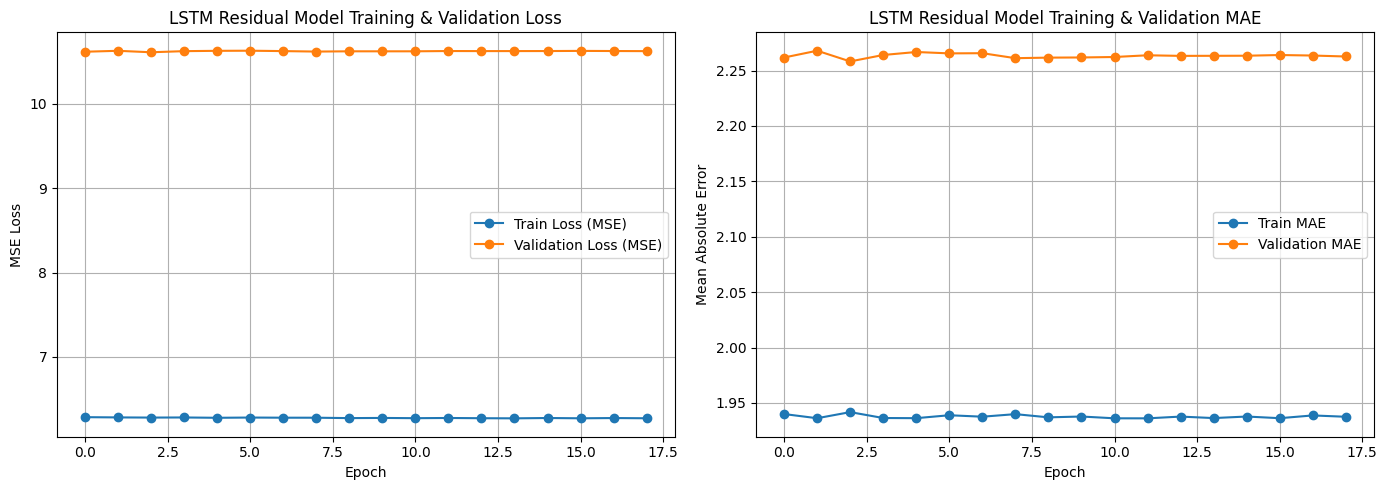

In [ ]:
# XGBoost + LSTM Stacking Ensemble with Meta Model V2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# ---------------------------------------------------
# 1. Mount Google Drive & Load Data
# ---------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/Data/2020_Data_V0.1.csv"
df = pd.read_csv(file_path)
print("Dataset preview:")
print(df.head())

# ---------------------------------------------------
# 2. Data Preprocessing & Feature Engineering
# ---------------------------------------------------
def convert_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df['Charging Time (seconds)'] = df['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)

# Process datetime and extract features.
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Start Hour'] = df['Start Date'].dt.hour
df['Start Day'] = df['Start Date'].dt.day
df['Start Month'] = df['Start Date'].dt.month
# NEW: Added day of week to capture weekly patterns.
df['Start DayOfWeek'] = df['Start Date'].dt.dayofweek

# Create Charging Duration Categories.
df['Charging Duration Category'] = pd.cut(
    df['Charging Time (seconds)'],
    bins=[0, 1800, 3600, 7200, 14400, np.inf],
    labels=['<30min', '30min-1hr', '1-2hr', '2-4hr', '>4hr']
)

# One-hot encode categorical features.
df = pd.get_dummies(df, columns=['Port Type', 'Charging Duration Category'], drop_first=True)

# Define feature list.
numeric_features = ['Charging Time (seconds)', 'Start Hour', 'Start Day', 'Start Month', 'Start DayOfWeek']
one_hot_features = [col for col in df.columns if col.startswith('Port Type_') or col.startswith('Charging Duration Category_')]
features = numeric_features + one_hot_features

X = df[features]
y = df['Energy (kWh)']

# ---------------------------------------------------
# 3. Normalize Features and Split Data
# ---------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Training (70%), Validation (15%), and Test (15%).
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nData Split:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# ---------------------------------------------------
# 4. Train the Enhanced XGBoost Model
# ---------------------------------------------------
print("XGBoost version:", xgb.__version__)

# Improvements:
# - Subsampling and column sampling to reduce overfitting.
# - Regularization parameters (reg_alpha, reg_lambda) are added.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Note: If your XGBoost version supports it, early_stopping_rounds could be used.
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Obtain XGBoost predictions.
pred_xgb_train = xgb_model.predict(X_train)
pred_xgb_val   = xgb_model.predict(X_val)
pred_xgb_test  = xgb_model.predict(X_test)

# Compute residuals on training and validation (for information only).
residual_train = y_train - pred_xgb_train
residual_val   = y_val - pred_xgb_val

# ---------------------------------------------------
# 5. Prepare Data for the LSTM Model
# ---------------------------------------------------
# Reshape data for LSTM: (samples, timesteps, features). Use a dummy timestep=1.
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm   = np.reshape(X_val,   (X_val.shape[0],   1, X_val.shape[1]))
X_test_lstm  = np.reshape(X_test,  (X_test.shape[0],  1, X_test.shape[1]))

# ---------------------------------------------------
# 6. Build and Train the LSTM Model on Residual Errors
# ---------------------------------------------------
# The LSTM is trained to predict the residual error (the difference between actual y and XGBoost prediction).
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(1, X_train.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='linear'))

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='mse',
                   metrics=['mae'])
lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_lstm = lstm_model.fit(
    X_train_lstm, (y_train - pred_xgb_train),  # Training on residuals.
    epochs=150,
    batch_size=32,
    validation_data=(X_val_lstm, (y_val - pred_xgb_val)),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Get LSTM predictions (i.e. residual corrections).
pred_lstm_train = lstm_model.predict(X_train_lstm).flatten()
pred_lstm_val   = lstm_model.predict(X_val_lstm).flatten()
pred_lstm_test  = lstm_model.predict(X_test_lstm).flatten()

# ---------------------------------------------------
# 7. Build a Meta Model for Stacking
# ---------------------------------------------------
# Instead of simply adding predictions (i.e., fixed weights), we now learn the best combination.
# For each sample, our meta-features are:
#   Feature 1: XGBoost prediction.
#   Feature 2: LSTM residual prediction.
meta_X_val = np.column_stack((pred_xgb_val, pred_lstm_val))
meta_model = LinearRegression().fit(meta_X_val, y_val)  # Train meta model on the validation set.

# Create meta features for training and test sets.
meta_X_train = np.column_stack((pred_xgb_train, pred_lstm_train))
meta_X_test  = np.column_stack((pred_xgb_test, pred_lstm_test))

# Final ensemble predictions using the meta model.
y_train_pred_final = meta_model.predict(meta_X_train)
y_val_pred_final   = meta_model.predict(meta_X_val)
y_test_pred_final  = meta_model.predict(meta_X_test)

# ---------------------------------------------------
# 8. Evaluate the Ensemble Performance
# ---------------------------------------------------
def print_metrics(y_true, y_pred, set_name="Dataset"):
    r2   = r2_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{set_name} Metrics:")
    print(f"R² Score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")

print("\nStacking Ensemble (XGBoost + LSTM + Meta Model) Performance:")
print_metrics(y_train, y_train_pred_final, "Training")
print_metrics(y_val, y_val_pred_final, "Validation")
print_metrics(y_test, y_test_pred_final, "Test")

# ---------------------------------------------------
# 9. Plot the LSTM Training History
# ---------------------------------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (MSE)', marker='o')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (MSE)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Residual Model Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE', marker='o')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('LSTM Residual Model Training & Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Reduce Overfitting:
Use Regularization → Apply dropout layers in the LSTM or L2 regularization.
Reduce Model Complexity → Try lowering the number of LSTM units or layers.
Increase Training Data → If possible, more data helps the model generalize better.
Improve Validation Performance:
Hyperparameter tuning:
Adjust learning rate, batch size, and dropout rates to find an optimal configuration.
Use Early Stopping with More Patience:
The model might need a few more epochs before stopping.
Evaluate Alternative Architectures:
If LSTM struggles with validation loss, try Bi-LSTM or GRU.
Consider other ensemble strategies, like stacking with different base models.